In [15]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from utils import seed_everything
from models import LeNet_Teacher, LeNet_Student
from training import train, train_kd
from testing import evaluate_cifar


In [2]:
seed_everything(0xbebebe)

In [3]:
# CIFAR-10
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
# model teacher
teacher_net = LeNet_Teacher()
teacher_criterion = nn.CrossEntropyLoss()
teacher_optimizer = optim.SGD(teacher_net.parameters(), lr=0.001, momentum=0.9)
teacher_epochs = 10

Epoch 10: 100%|██████████| 782/782 [00:21<00:00, 36.91it/s, Loss=0.876]


Finished Training
Inference | Elapsed time : 1.56
Accuracy: 0.6639
Precision: 0.667116274975517
Recall: 0.6639
F1-Score: 0.6596887078947676


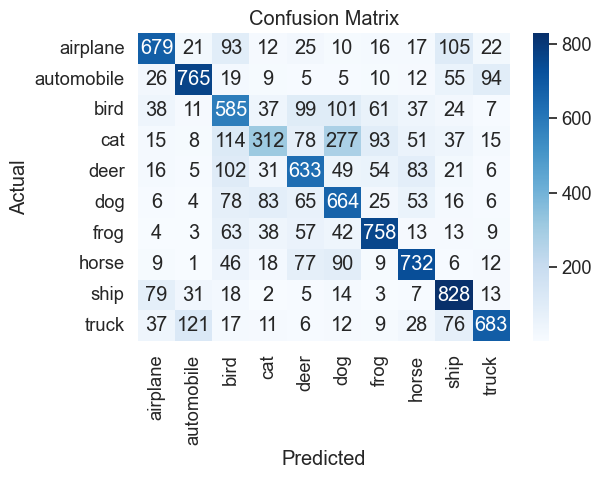

In [6]:
train(teacher_net, teacher_criterion, teacher_optimizer, trainloader, teacher_epochs)
evaluate_cifar(teacher_net, testloader, testset)

In [10]:
torch.save(teacher_net, 'teacher_net.pt')
print(f'teacher_net size is {os.path.getsize("teacher_net.pt") / 2 ** 10:.1f} Kb')

teacher_net size is 1094.1 Kb


In [11]:
# model student
student_net = LeNet_Student()
student_criterion = nn.CrossEntropyLoss()
student_optimizer = optim.SGD(student_net.parameters(), lr=0.001, momentum=0.9)
student_epochs = 10

Epoch 10: 100%|██████████| 782/782 [00:12<00:00, 61.67it/s, Loss=1.2] 


Finished Training
Inference | Elapsed time : 0.94
Accuracy: 0.5712
Precision: 0.5667111659828682
Recall: 0.5712
F1-Score: 0.5653948254958936


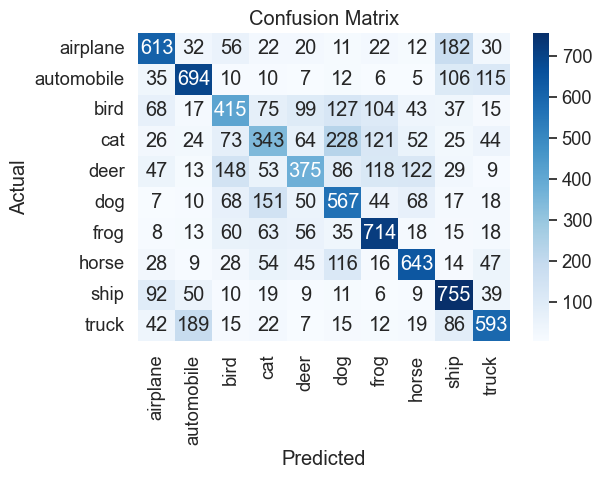

In [12]:
train(student_net, student_criterion, student_optimizer, trainloader, student_epochs)
evaluate_cifar(student_net, testloader, testset)

# KD

In [17]:
student_net = LeNet_Student()
kd_optimizer = optim.SGD(student_net.parameters(), lr=0.001, momentum=0.9)

In [18]:
train_kd(teacher_net, 
        student_net,
        kd_optimizer, 
        trainloader, 
        epochs=10,
        temperature=2.0,
        alpha=0.7)


Epoch 10: 100%|██████████| 782/782 [00:17<00:00, 43.74it/s, kd_loss=0.374, label_loss=1.12, total_loss=0.597]

Finished knowledge distillation


Inference | Elapsed time : 1.09
Accuracy: 0.5955
Precision: 0.5965056332110203
Recall: 0.5955
F1-Score: 0.5898944667675763


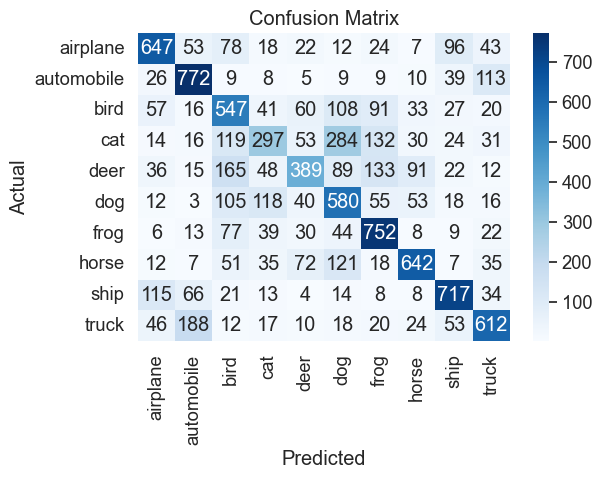

In [19]:
evaluate_cifar(student_net, testloader, testset)

In [20]:
torch.save(student_net, 'student_net.pt')
print(f'student_net size is {os.path.getsize("student_net.pt") / 2 ** 10:.1f} Kb')

student_net size is 247.2 Kb


In [24]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

total_params_student = count_parameters(student_net)
total_params_teacher = count_parameters(teacher_net)

print(f"Total trainable parameters for student: {total_params_student}")
print(f"Total trainable parameters for teacher: {total_params_teacher}")

decrease = (total_params_teacher - total_params_student) / total_params_teacher
print(f'Модель студента имеет на {decrease*100:.2f} % меньше параметров, чем модель учителя')

Total trainable parameters for student: 62006
Total trainable parameters for teacher: 278780
Модель студента имеет на 77.76 % меньше параметров, чем модель учителя
